In [1]:
# If using google drive, unocmment these 2 lines for accessing your myDrive folder
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

# NLP libraries
import spacy

# scikit imports
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

# Setting a seed to reproduce
seed = 42
random.seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2

# Enter here your local path to labelled data
PATH = ''

In [3]:
# Initialize the Spacy analyzer in English
nlp = spacy.load('en_core_web_sm')

In [4]:
# Loading train data
df_train = pd.read_csv(PATH + "Title_Train_Label.csv")
# Making sure the green_content is not a string but an integer
df_train['green_title'] = df_train['green_title'].astype(int).replace({-1: 2})
df_train.head()

,Unnamed: 0,title,green_title
0,0,Senior Search Partner Manager,0
1,1,Head of Proposals,0
2,2,EURO Broadcast Venue Manager,0
3,3,(m/f) TEMP - Receptionist,2
4,4,Corporate Accountant  Tempo Mission  Sun system,2


In [5]:
# Loading validation data
df_validate = pd.read_csv(PATH + "Title_Validation_Label.csv")
# Making sure the green_content is not a string but an integer
df_validate['green_title'] = df_validate['green_title'].astype(int).replace({-1: 2})
df_validate.head()

,title,title_tokens,green_title
0,Betriebsmitarbeiter/in,['betriebsmitarbeiter'],2
1,Infirmière Camp d'été,"['infirmière', 'camp', ""d'été""]",1
2,Customer Service Industrialisation Manager (m/w),"['customer', 'service', 'industrialisation', '...",0
3,HR-Manager with particular focus on change-man...,"['manager', 'particular', 'focus', 'change', '...",2
4,Java Backend Developer - Business Rule Develop...,"['java', 'backend', 'developer', 'business', '...",2


In [6]:
df_test = pd.read_csv(PATH + "Test_Final.csv")
df_test.head()

,title,content_no_custom_words,title_tokens,content_tokens,manual green
0,Business Process Engineers / Software Entwickl...,business process engineers / software entwickl...,"['business', 'process', 'engineer', 'software'...","['business', 'process', 'engineer', 'software'...",0
1,Kranführer/in mit SUVA Ausweis,kranführer/in mit suva ausweis kranführer/in...,"['kranführer', 'suva', 'ausweis']","['kranführer', 'suva', 'ausweis', 'kranführer'...",0
2,Sachbearbeiter/in Visa,sachbearbeiter/in visa sachbearbeiter/in vis...,"['sachbearbeiter', 'visa']","['sachbearbeiter', 'visa', 'sachbearbeiter', '...",0
3,Soft Commodity Trading Jr Operator,the junior operator will be in charge of: - ma...,"['soft', 'commodity', 'trading', 'operator']","['junior', 'operator', 'charge', 'manage', 'bu...",0
4,Software Trainer,software trainer details job title software tr...,"['software', 'trainer']","['software', 'trainer', 'detail', 'title', 'so...",0


### Assembling all words to create a corpus

In [7]:
# Transform dataset to list
list_corpus_train      = df_train['title'].tolist()
list_corpus_val        = df_validate['title'].tolist()
list_corpus_test       = df_test['title'].tolist()

# Adding all lists together
corpus_total           = list_corpus_train + list_corpus_val + list_corpus_test

# Define CountVectorizer
vectorizer             = CountVectorizer()
X_TrainValidateandTest = vectorizer.fit_transform(corpus_total)
values                 = vectorizer.get_feature_names()

### Split into train, validation and test

In [8]:
# Train
index_stop_train     = df_train.shape[0]
X_train              = X_TrainValidateandTest[0:index_stop_train]

# Validation
index_start_validate = df_train.shape[0]
index_stop_validate  = df_train.shape[0] + df_validate.shape[0]
X_validate           = X_TrainValidateandTest[index_start_validate:index_stop_validate]

# Test
index_start_test     = df_train.shape[0] + df_validate.shape[0]
index_stop_test      = X_TrainValidateandTest.shape[0]
X_test               = X_TrainValidateandTest[index_start_test:index_stop_test]

In [9]:
# Prepare Y 
Y_train    = df_train['green_title'].astype(int)
Y_validate = df_validate['green_title'].astype(int) 
Y_test     = df_test['manual green'].astype(int)

In [10]:
# Verifying the dimensions
print(X_train.shape, Y_train.shape, X_validate.shape, Y_validate.shape, X_test.shape, Y_test.shape)

(16193, 7001) (16193,) (534, 7001) (534,) (300, 7001) (300,)


### Let's fit the regularized logistic regression. We will crossvalidate the regularization parameter on the training set.

In [11]:
# Create empty list to store scores
accs = []

# The grid of regularization parameter 
grid = np.linspace(0.005,10,100)

for c in grid:
    # Initialize the classifier
    model = LogisticRegression(random_state=0, solver='lbfgs', C = c)
    model.fit(X_train, Y_train)
    scores = model.score(X_validate, Y_validate)
    accs.append(np.mean(scores))

#### Plot crossvalidation accuracy over regularization parameter

Text(0, 0.5, 'Crossvalidation accuracy')

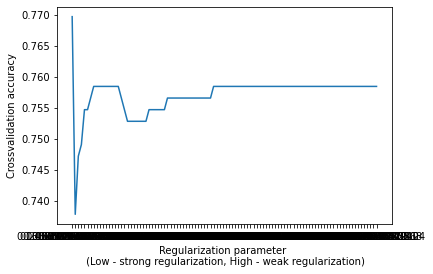

In [12]:
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')

### Printing the most common words caracterizing greenness

In [13]:
coefs     = model.coef_[0]
top_three = np.argpartition(coefs, -20)[-20:]

print(np.array(vectorizer.get_feature_names())[top_three])

['metabolic' 'vorarbeiter' 'physicist' 'regional' 'bi' 'dpt' 'cns' '40'
 'biologielaborant' 'actuar' 'metabolism' 'fachmitarbeiterin' 'imaging'
 'bereich' 'formulation' 'betriebschemiker' 'trials' 'bio' 'newoem'
 'congo']


### Printing the most common words caracterizing non-greenness

In [14]:
coefs     = model.coef_[2]
top_three = np.argpartition(coefs, -20)[-20:]

print(np.array(vectorizer.get_feature_names())[top_three])

['bank' 'broker' 'clerk' 'oil' 'investment' 'receptionist'
 'administrative' 'financial' 'finance' 'auditor' 'commerce' 'secretary'
 'actuary' 'marketing' 'einkauf' 'tax' 'software' 'accountant' 'insurance'
 'credit']


### Let's train again, on the entire training set, with the chosen regularization parameter. We will test on the test set

In [15]:
# Predictions on test set
y_pred = model.predict(X_test)
y_pred

array([2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 1, 2,
       0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0])

In [16]:
df_test['title_prediction'] = y_pred
df_test['title_prediction'] = df_test['title_prediction'].replace({2:-1})
df_test.to_csv(PATH + 'Title_Prediction_VectRLR.csv', index=False)
df_test.head()

,title,content_no_custom_words,title_tokens,content_tokens,manual green,title_prediction
0,Business Process Engineers / Software Entwickl...,business process engineers / software entwickl...,"['business', 'process', 'engineer', 'software'...","['business', 'process', 'engineer', 'software'...",0,-1
1,Kranführer/in mit SUVA Ausweis,kranführer/in mit suva ausweis kranführer/in...,"['kranführer', 'suva', 'ausweis']","['kranführer', 'suva', 'ausweis', 'kranführer'...",0,0
2,Sachbearbeiter/in Visa,sachbearbeiter/in visa sachbearbeiter/in vis...,"['sachbearbeiter', 'visa']","['sachbearbeiter', 'visa', 'sachbearbeiter', '...",0,0
3,Soft Commodity Trading Jr Operator,the junior operator will be in charge of: - ma...,"['soft', 'commodity', 'trading', 'operator']","['junior', 'operator', 'charge', 'manage', 'bu...",0,0
4,Software Trainer,software trainer details job title software tr...,"['software', 'trainer']","['software', 'trainer', 'detail', 'title', 'so...",0,-1


### Plot confusion matrix

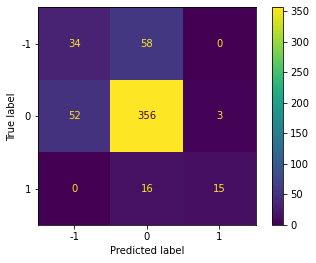

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predicting on validation set
val_preds = model.predict(X_validate)

# Changing labels back from 2 to -1
val_preds = np.where(val_preds == 2, -1, val_preds)
Y_validate = np.where(Y_validate == 2, -1, Y_validate)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_validate, val_preds), display_labels=np.unique(val_preds))
disp.plot()

# Alternative by fixing the class distribution

In [18]:
# Percent distribution of green jobs wanted
wanted_green_distribution = 5
wanted_not_green_distribution = 10

y_pred = model.predict_proba(X_test)
df_test.loc[:, 'title_prediction'] = 0
df_test.loc[y_pred[:,1] > np.quantile(y_pred[:,1], 1-wanted_green_distribution/100), 'title_prediction'] = 1
df_test.loc[y_pred[:,2] > np.quantile(y_pred[:,2], 1-wanted_not_green_distribution/100), 'title_prediction'] = -1

In [19]:
df_test.to_csv(PATH + 'Title_Prediction_VectRLR_fixed.csv', index=False)

In [20]:
val_preds

array([ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  1,
        0, -1,  0,  0, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1, -1,  0,  1,
       -1, -1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,
        0, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,
        0, -1,  0,  0,  0

In [21]:
Y_validate

array([-1,  1,  0, -1, -1,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0, -1,  1,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1, -1,
       -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0, -1,  1,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0, -1, -1,
        0, -1, -1,  0,  0